Get a 3D pulse map for each subject and output it with phase of each fMRI time point for each subject

In [1]:
import pandas as pd
import nibabel as nib
import numpy as np
from scipy.signal import find_peaks
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import clean_img
from nilearn.image import new_img_like
from sklearn.metrics import r2_score
from nilearn.image import mean_img
import os


In [2]:
# get subjects from subjects.txt:
# Path to your subject list file
subjects_file = r"D:\HCP_vessel_files\subjects.txt"

# Read all IDs into a Python list
with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]

print("Loaded", len(subjects), "subjects:")

# subjects = subjects[:10] # only do the first 10 subjects:
# subjects = subjects[7:17] # only do the first 10 subjects:, skipping 103818 for now
# subjects = subjects[17:27]
# subjects = subjects[27:37]
# subjects = subjects[37:100] 

print(subjects)  # show the first 10 to check


Loaded 190 subjects:
['100307', '101309', '102008', '102311', '103111', '103414', '103818', '105014', '107422', '108828', '109123', '110411', '111716', '113619', '113821', '113922', '114419', '115320', '116524', '118528', '118932', '120212', '121618', '123420', '124220', '124826', '127630', '128127', '129533', '130013', '132118', '133827', '136833', '137027', '137128', '137936', '138231', '140117', '140824', '142424', '142828', '143325', '144832', '145531', '146331', '146432', '148941', '150423', '150726', '151627', '153833', '154734', '154936', '155635', '156637', '158035', '159138', '161630', '161731', '162733', '163331', '164131', '165032', '167743', '168341', '169343', '169444', '170934', '172130', '172938', '173536', '175035', '177645', '178950', '179346', '180129', '180836', '180937', '181232', '183034', '185139', '186141', '187143', '187547', '188347', '189349', '191033', '191437', '191841', '192540', '192843', '194140', '194847', '195849', '197348', '198855', '199150', '199251'

In [3]:
n_volumes = 1200  # HCP resting scan has 1200 volumes
TR = 0.72  # seconds
sampling_rate = 400  # Hz # Sampling rate (HCP standard)


In [4]:
# Generate slice timing for HCP resting state
def generate_hcp_slice_timing(n_slices=72, multiband_factor=8, TR=0.72):
    n_groups = n_slices // multiband_factor  # 9 groups
    slice_timing = np.zeros(n_slices)
    for slice_idx in range(n_slices):
        group_idx = slice_idx % n_groups
        slice_timing[slice_idx] = (group_idx / n_groups) * TR
    return slice_timing
from scipy.stats import binned_statistic


In [5]:
# code to use the physio data to get the alignment data: 

for subjectid in subjects:
    file_path = fr"D:\hcp_processed\{subjectid}\{subjectid}_REST1_LR_cardiac_alignment_data.npz"
    if os.path.exists(file_path):
        print(f"Skipping {subjectid}, file already exists.")
        continue  # Skip this subject
    else:
        print(f"Processing {subjectid}...")

    # print(f"subject {subjectid}")
    
    hcp_physio_path = fr"D:\hcp_data\{subjectid}\unprocessed\3T\rfMRI_REST1_LR\LINKED_DATA\PHYSIO\{subjectid}_3T_rfMRI_REST1_LR_Physio_log.txt"
    physio_data = np.loadtxt(hcp_physio_path)
    print(f"✅ Loaded physio file, shape: {physio_data.shape}")     # Check shape
    n_samples = physio_data.shape[0]

    scan_duration = n_volumes * TR  # Total seconds
    sampling_rate = n_samples / scan_duration     # Estimated sampling rate
    print(f"✅ Estimated Sampling Rate: {sampling_rate:.2f} Hz")

    pulse = physio_data[:, 2]
    resp = physio_data[:, 1]
    
    # find peaks for the phase realignment. 
    peak_distance = int(0.55 * sampling_rate)  # Expected ~500-600 ms between heartbeats
    peaks, _ = find_peaks(pulse, height=np.mean(pulse)*1.1, distance=peak_distance)
    print(f"✅ Found {len(peaks)} pulse peaks.")

    subject_data_physio = {}
    subject = f'{subjectid}_REST1_LR'
    subject_data_physio[subject] = {
        "pulse": pulse,
        "resp": resp,
        "peaks": peaks,
        "sampling_rate": sampling_rate,
    }

    # w/ motion correction
    fmri_nifti_file = fr"D:\hcp_processed\{subjectid}\motion_corrected\{subjectid}_REST1_LR_mc.nii.gz"
    fmri_img = nib.load(fmri_nifti_file)
    nifti_shape = fmri_img.shape     # Get dimensions
    num_volumes = nifti_shape[-1]
    print(f"✅ fMRI file loaded: shape = {nifti_shape}, num volumes = {num_volumes}")

    slice_timing = generate_hcp_slice_timing()
    num_slices = len(slice_timing)
    # Compute fMRI times for each slice
    fmri_times = np.zeros((num_slices, num_volumes))
    for s in range(num_slices):
        for t in range(num_volumes):
            fmri_times[s, t] = (t * TR) + slice_timing[s]
    # print(f"✅ Computed fMRI times for {num_slices} slices and {num_volumes} volumes.")
    # Store in dictionary
    subject_data_fMRI = {}
    subject = f'{subjectid}_REST1_LR'
    subject_data_fMRI[subject] = {
        "TR": TR,
        "slice_timing": slice_timing,
        "num_slices": num_slices,
        "num_volumes": num_volumes,
        "fmri_times": fmri_times
    } 


    ts = (1/subject_data_physio[subject]['sampling_rate'])
    time = np.arange(len(subject_data_physio[subject]['pulse'])) * ts
    heartbeat_times = time[peaks]  # Time of detected heartbeats
    TR = subject_data_fMRI[subject]['TR']
    # with frequency filtering
    # high_pass = 0.0042
    # convert to % change here?
    # fmri_img = clean_img(fmri_img, detrend=True, high_pass = high_pass, standardize=False, t_r=TR) # does nothing here, not using fMRI data
    fmri_data = fmri_img.get_fdata() # use detrended data 

    # # Set output path per subject
    output_dir = fr"D:\hcp_processed\{subjectid}"
    # os.makedirs(output_dir, exist_ok=True) # if saving cardiac-aligned data: 
    # # Save dictionary with valid indices and cardiac phase per slice
    save_path = os.path.join(output_dir, f"{subject}_cardiac_alignment_data.npz") 
    # Create storage dictionary
    cardiac_alignment_info = {
        "valid_fmri_indices": {},  # keys: slice_idx
        "cardiac_phase": {}        # keys: slice_idx
    } 

    fmri_slices = []
    theta_slices = []

    for slice_idx  in np.arange(fmri_data.shape[2]):
        fmri_times = subject_data_fMRI[subject]['fmri_times'][slice_idx, :]
        fmri_data_2D = fmri_data[:,:,slice_idx,:]
        fmri_data_2D = fmri_data_2D.reshape(fmri_data.shape[0]*fmri_data.shape[1], fmri_data.shape[3])
        
        prev_heartbeats = []
        next_heartbeats = []

        for t in fmri_times:
            idx = np.searchsorted(heartbeat_times, t)  # Find insertion index
            # Previous heartbeat time (if exists)
            if idx > 0:
                prev_heartbeats.append(heartbeat_times[idx - 1])
            else:
                prev_heartbeats.append(None)  # No previous heartbeat
            # Next heartbeat time (if exists)
            if idx < len(heartbeat_times):
                next_heartbeats.append(heartbeat_times[idx])
            else:
                next_heartbeats.append(None)  # No next heartbeat
        prev_heartbeats = np.array(prev_heartbeats, dtype=np.float64)
        next_heartbeats = np.array(next_heartbeats, dtype=np.float64)

        # cardiac phase for this slice and this subject
        cardiac_phase = (fmri_times - prev_heartbeats) / (next_heartbeats - prev_heartbeats)

        valid_fmri_indices = (fmri_times >= heartbeat_times[0]) & (fmri_times <= heartbeat_times[-1])
        # aligned fMRI data and phase.
        fmri_data_2D_trunc = fmri_data_2D[:, valid_fmri_indices]
        theta = cardiac_phase[valid_fmri_indices]  # Keep only valid phases
        fmri_times = fmri_times[valid_fmri_indices]

        # Step 1: Identify heartbeat intervals (pairs of consecutive heartbeats)
        heartbeat_intervals = list(zip(heartbeat_times[:-1], heartbeat_times[1:]))
        # print(heartbeat_intervals)
        fmri_slices.append(fmri_data_2D_trunc.reshape(90, 104, -1))
        theta_slices.append(theta)

        # save cardiac_phase as the phase at each time point, save valid fMRI indices for which points to remove, bin in the new file. 
        cardiac_alignment_info["valid_fmri_indices"][slice_idx] = valid_fmri_indices
        cardiac_alignment_info["cardiac_phase"][slice_idx] = cardiac_phase

    # After the slice loop ends, save everything once
    np.savez(save_path, **cardiac_alignment_info)
    print(f"💾 Saved cardiac alignment info to: {save_path}")




Skipping 100307, file already exists.
Skipping 101309, file already exists.
Skipping 102008, file already exists.
Skipping 102311, file already exists.
Skipping 103111, file already exists.
Skipping 103414, file already exists.
Skipping 103818, file already exists.
Skipping 105014, file already exists.
Skipping 107422, file already exists.
Skipping 108828, file already exists.
Skipping 109123, file already exists.
Skipping 110411, file already exists.
Skipping 111716, file already exists.
Skipping 113619, file already exists.
Skipping 113821, file already exists.
Skipping 113922, file already exists.
Skipping 114419, file already exists.
Skipping 115320, file already exists.
Skipping 116524, file already exists.
Skipping 118528, file already exists.
Skipping 118932, file already exists.
Skipping 120212, file already exists.
Skipping 121618, file already exists.
Skipping 123420, file already exists.
Skipping 124220, file already exists.
Skipping 124826, file already exists.
Skipping 127

Loaded 190 subjects:
['100307', '101309', '102008', '102311', '103111', '103414', '103818', '105014', '107422', '108828']
subject 100307
✅ Loaded physio file, shape: (345604, 3)
✅ Estimated Sampling Rate: 400.00 Hz
✅ Mean heart rate: 76.9 BPM


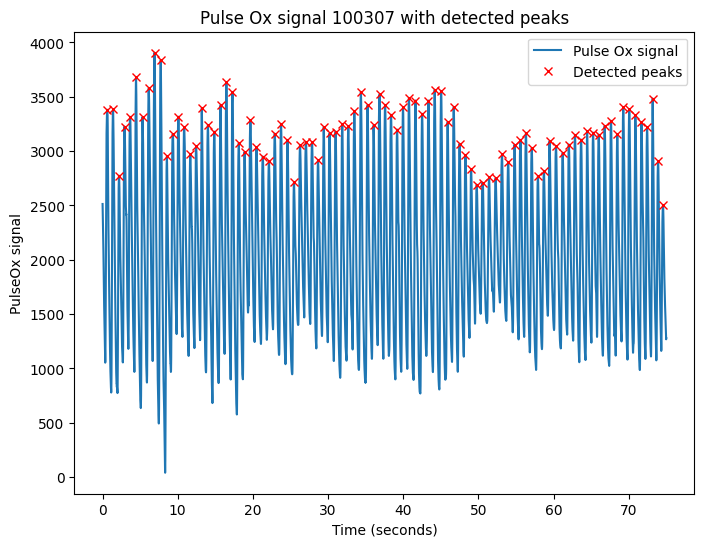

subject 101309
✅ Loaded physio file, shape: (345605, 3)
✅ Estimated Sampling Rate: 400.01 Hz
✅ Mean heart rate: 63.3 BPM


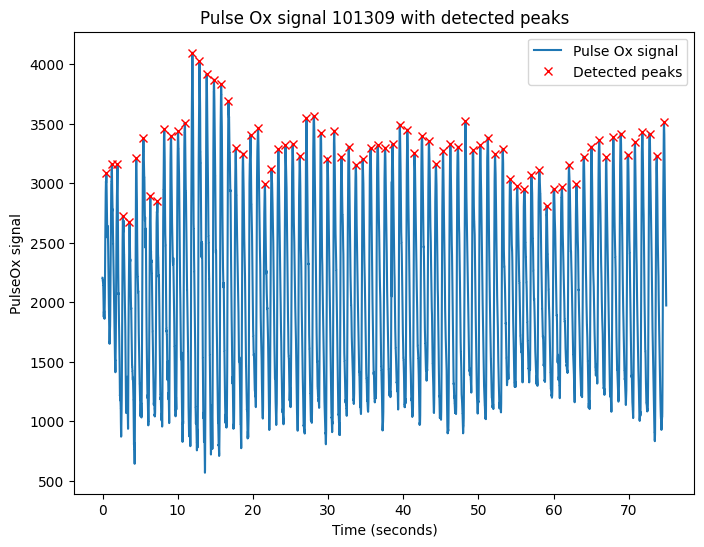

subject 102008
✅ Loaded physio file, shape: (345605, 3)
✅ Estimated Sampling Rate: 400.01 Hz
✅ Mean heart rate: 44.9 BPM


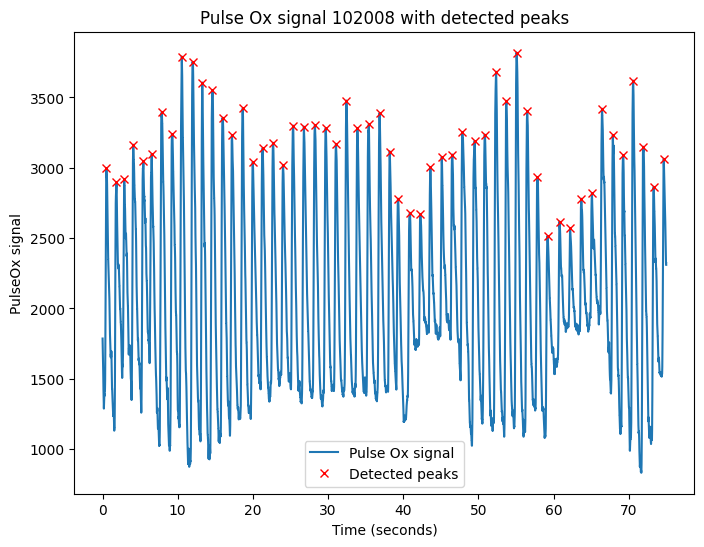

subject 102311
✅ Loaded physio file, shape: (345605, 3)
✅ Estimated Sampling Rate: 400.01 Hz
✅ Mean heart rate: 62.2 BPM


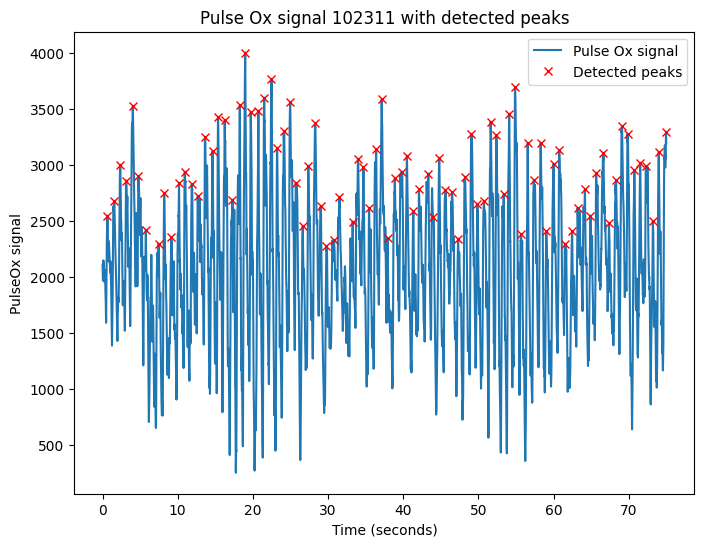

subject 103111
✅ Loaded physio file, shape: (345605, 3)
✅ Estimated Sampling Rate: 400.01 Hz
✅ Mean heart rate: 89.4 BPM


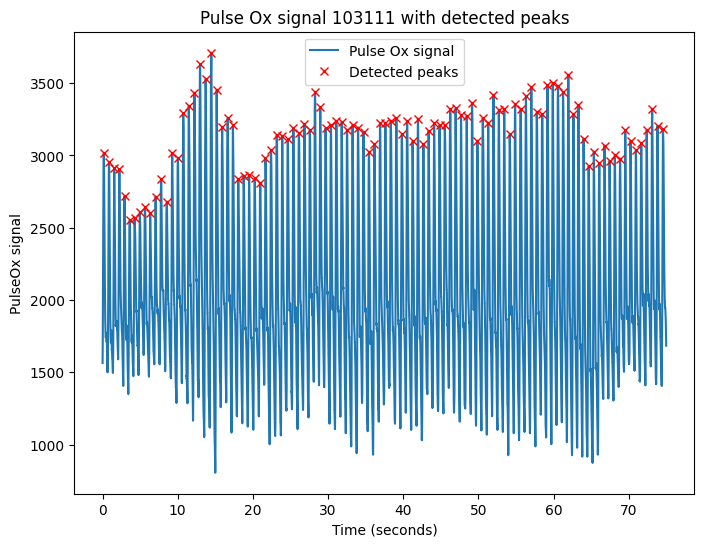

subject 103414
✅ Loaded physio file, shape: (345605, 3)
✅ Estimated Sampling Rate: 400.01 Hz
✅ Mean heart rate: 48.0 BPM


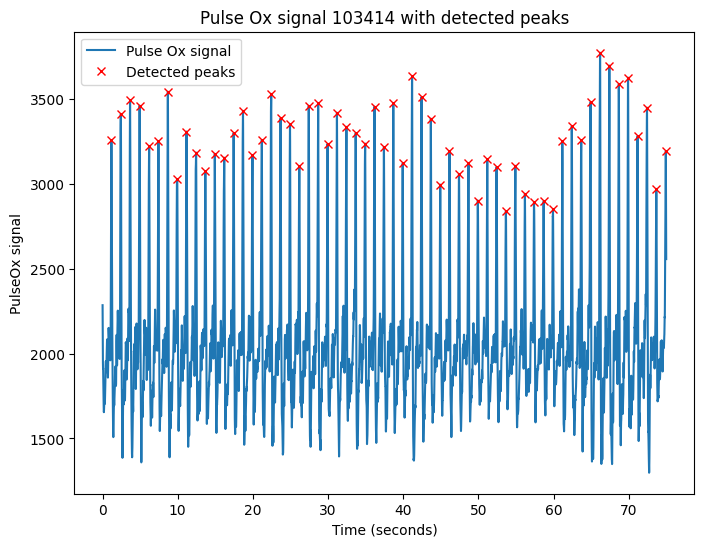

subject 103818
✅ Loaded physio file, shape: (345604, 3)
✅ Estimated Sampling Rate: 400.00 Hz
✅ Mean heart rate: 91.8 BPM


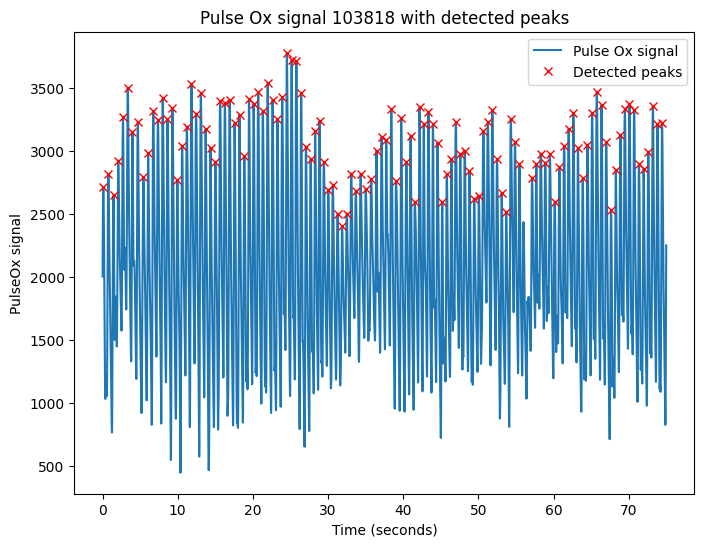

subject 105014
✅ Loaded physio file, shape: (345605, 3)
✅ Estimated Sampling Rate: 400.01 Hz
✅ Mean heart rate: 63.3 BPM


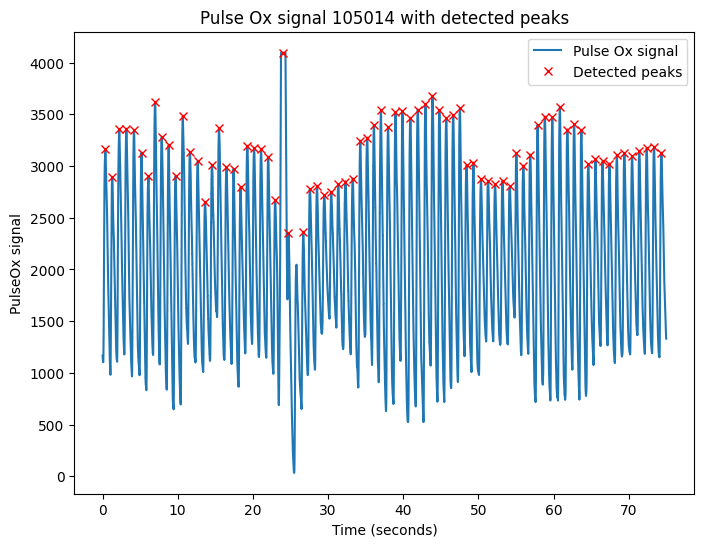

subject 107422
✅ Loaded physio file, shape: (345605, 3)
✅ Estimated Sampling Rate: 400.01 Hz
✅ Mean heart rate: 52.0 BPM


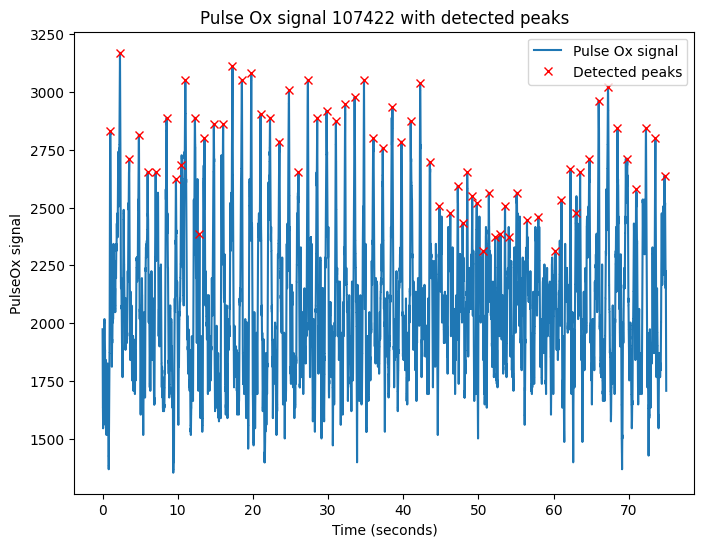

subject 108828
✅ Loaded physio file, shape: (345604, 3)
✅ Estimated Sampling Rate: 400.00 Hz
✅ Mean heart rate: 69.6 BPM


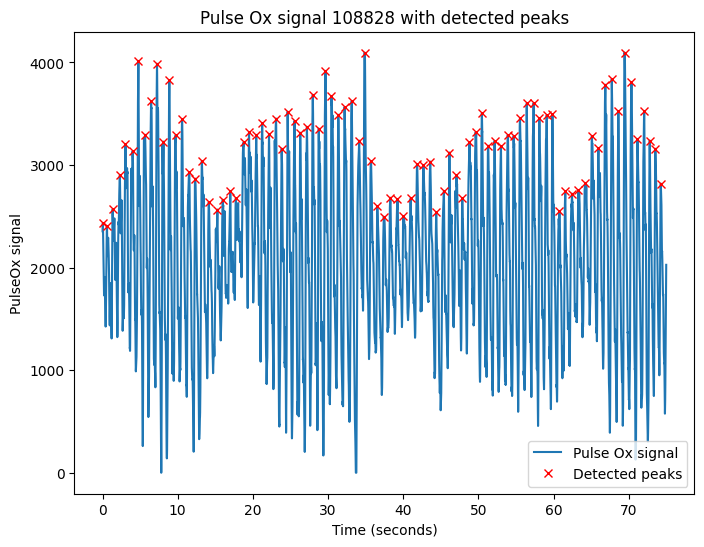

In [ ]:
# Code to visualize the PPG data to check it. 
# get subjects from subjects.txt:
# Path to your subject list file
subjects_file = r"D:\HCP_vessel_files\subjects.txt"
# Read all IDs into a Python list
with open(subjects_file, "r") as f:
    subjects = [line.strip() for line in f if line.strip()]
print("Loaded", len(subjects), "subjects:")
subjects = subjects[:10] 
print(subjects)  # show the first 10 to check

for subjectid in subjects:
    print(f"subject {subjectid}")
    hcp_physio_path = fr"D:\hcp_data\{subjectid}\unprocessed\3T\rfMRI_REST1_LR\LINKED_DATA\PHYSIO\{subjectid}_3T_rfMRI_REST1_LR_Physio_log.txt"
    physio_data = np.loadtxt(hcp_physio_path)
    print(f"✅ Loaded physio file, shape: {physio_data.shape}")     # Check shape
    n_samples = physio_data.shape[0]

    scan_duration = n_volumes * TR  # Total seconds
    sampling_rate = n_samples / scan_duration     # Estimated sampling rate
    print(f"✅ Estimated Sampling Rate: {sampling_rate:.2f} Hz")

    pulse = physio_data[:, 2]
    resp = physio_data[:, 1]
    # Now you can process peaks 
    peak_distance = int(0.55 * sampling_rate)  # Expected ~500-600 ms between heartbeats
    peaks, _ = find_peaks(pulse, height=np.mean(pulse)*1.1, distance=peak_distance)
    # print(f"✅ Found {len(peaks)} pulse peaks.")
    # print estimated heart rate: 

    # Total time of scan (sec)
    duration_sec = n_samples / sampling_rate  
    # Beats per second
    bps = len(peaks) / duration_sec  
    # Convert to beats per minute
    bpm = bps * 60  
    print(f"✅ Mean heart rate: {bpm:.1f} BPM")


    time_vector = np.arange(len(pulse)) / sampling_rate
    plt.figure(figsize=(8, 6))
    index = 30000 # 4000
    plt.plot(time_vector[:index], pulse[:index], label='Pulse Ox signal')
    plt.plot(time_vector[peaks[(peaks < index)]], pulse[peaks[(peaks < index)]], 'rx', label='Detected peaks')
    plt.xlabel('Time (seconds)')
    plt.ylabel('PulseOx signal')
    plt.title(f'Pulse Ox signal {subjectid} with detected peaks')
    plt.legend()
    plt.show()



